In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import *
from datetime import time, tzinfo, timedelta, datetime
%matplotlib inline

In [2]:
client = MongoClient('52.79.239.183', 27017)
print("DB connection complete!!")

DB connection complete!!


In [3]:
def Get_each_Coin_DF(coinName):
    DB_Coin = client[coinName]
    Collection = DB_Coin['BTC/USD_30MIN']
    DB_schema = []
    for collect in Collection.find():
        temp_record = {}
        temp_record[coinName] = collect['price_close']
        temp_record['Date'] = collect['time_period_end']
        temp_record['label'] = coinName
        temp_record[coinName+'vol'] = collect['volume_traded']
        DB_schema.append(temp_record)
        del temp_record
    
    DF = pd.DataFrame(DB_schema)
    DF['Date'] = DF['Date'].apply(pd.to_datetime, errors='coerce')
    DF.index = DF['Date']
    DF = DF.sort_values(by='Date')
    DF = DF[[coinName, coinName+'vol']] # remove Date Column
    DF[coinName].plot()
    return DF
    
    

In [38]:
a = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
print(a[:-4])
print(a[4:])


[1, 1.5, 2, 2.5, 3, 3.5]
[3, 3.5, 4, 4.5, 5, 5.5]


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


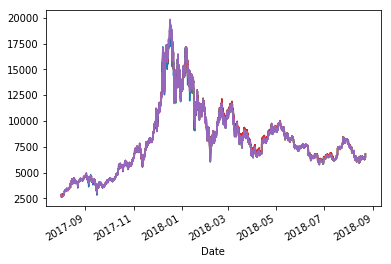

In [4]:
BinanceDF = Get_each_Coin_DF("BINANCE")
HuobiDF = Get_each_Coin_DF("HUOBI")
OkexDF = Get_each_Coin_DF("OKEX")
HitbtcDF = Get_each_Coin_DF("HITBTC")
BitfinexDF = Get_each_Coin_DF("BITFINEX")
#######################
#BitmexDF = Get_each_Coin_DF("BITMEX")
#BitstampDF = Get_each_Coin_DF("BITSTAMP")
#CoinbaseDF = Get_each_Coin_DF("COINBASE")
#PoloniexDF = Get_each_Coin_DF("POLONIEX")

In [5]:
BinanceDF.head()

,BINANCE,BINANCEvol
Date,,
2017-08-17 04:30:00,4261.45,11.308926
2017-08-17 05:00:00,4308.83,35.872083
2017-08-17 05:30:00,4320.00,21.048648
2017-08-17 06:00:00,4315.32,2.186268
2017-08-17 06:30:00,4311.02,3.566277


### Vertically merging DataFrame

In [ ]:
NewDF = pd.concat([BinanceDF, HuobiDF, OkexDF, HitbtcDF, BitfinexDF])
NewDF.head()

In [ ]:
NewDF.boxplot()

### Horizontally merging DataFrame

In [7]:
JoinedDF = pd.merge(BinanceDF, HuobiDF, how='inner', left_index=True, right_index=True)
#for df in [OkexDF, HitbtcDF, BitfinexDF, BitmexDF, BitstampDF, CoinbaseDF, PoloniexDF]:
for df in [OkexDF, HitbtcDF, BitfinexDF]:
    JoinedDF = pd.merge(JoinedDF, df, how='inner', left_index=True, right_index=True)

JoinedDF.head()

,BINANCE,BINANCEvol,HUOBI,HUOBIvol,OKEX,OKEXvol,HITBTC,HITBTCvol,BITFINEX,BITFINEXvol
Date,,,,,,,,,,
2018-01-25 01:00:00,11297.94,365.021829,11262.36,50.272016,11290.7872,141.145173,11288.70,17.92,11287.0,488.043468
2018-01-25 07:30:00,11482.19,443.701462,11550.30,60.393940,11472.0001,153.589501,11426.98,1.43,11440.0,667.999582
2018-01-25 08:00:00,11460.00,340.543915,11499.90,62.753972,11472.0002,130.173960,11378.12,28.01,11403.0,787.747119
2018-01-25 08:30:00,11369.75,594.173836,11327.40,182.079494,11353.2086,140.744857,11305.40,84.53,11322.0,722.283291
2018-01-25 09:00:00,11275.00,378.418509,11320.00,164.262173,11293.3581,135.823050,11299.37,62.54,11268.0,353.515281


In [8]:
Top5 = ['BINANCE', 'HUOBI', 'OKEX', 'HITBTC', 'BITFINEX']
VolDF = JoinedDF[['BINANCEvol', 'HUOBIvol', 'OKEXvol', 'HITBTCvol', 'BITFINEXvol']]
JoinedDF = JoinedDF[Top5]

In [ ]:
Top10 = ['BINANCE', 'HUOBI', 'OKEX', 'HITBTC', 'BITFINEX', "BITMEX", "BITSTAMP", "COINBASE", 'POLONIEX']
VolDF = JoinedDF[['BINANCEvol', 'HUOBIvol', 'OKEXvol', 'HITBTCvol', 'BITFINEXvol', "BITMEXvol", "BITSTAMPvol", 'COINBASEvol', 'POLONIEXvol']]
JoinedDF = JoinedDF[Top10]

## Volume Information

In [11]:
print(VolDF.shape)

(8462, 5)


In [31]:
Time_main = list(JoinedDF.index)
JoinedDF = JoinedDF[Top5]

Data_to_plot = []
Data_xvalue = []
Data_median = []
for ii in Time_main:
    try:
        idx = ii.strftime('%Y-%m-%d %H:%M:%S') 
        Data_to_plot.append(tuple(JoinedDF.loc[idx]))
        Data_median.append(np.median(tuple(JoinedDF.loc[idx])))
        Data_xvalue.append(idx)
    except KeyError as ke:
        print(ke)
        

TypeError: cannot perform reduce with flexible type

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

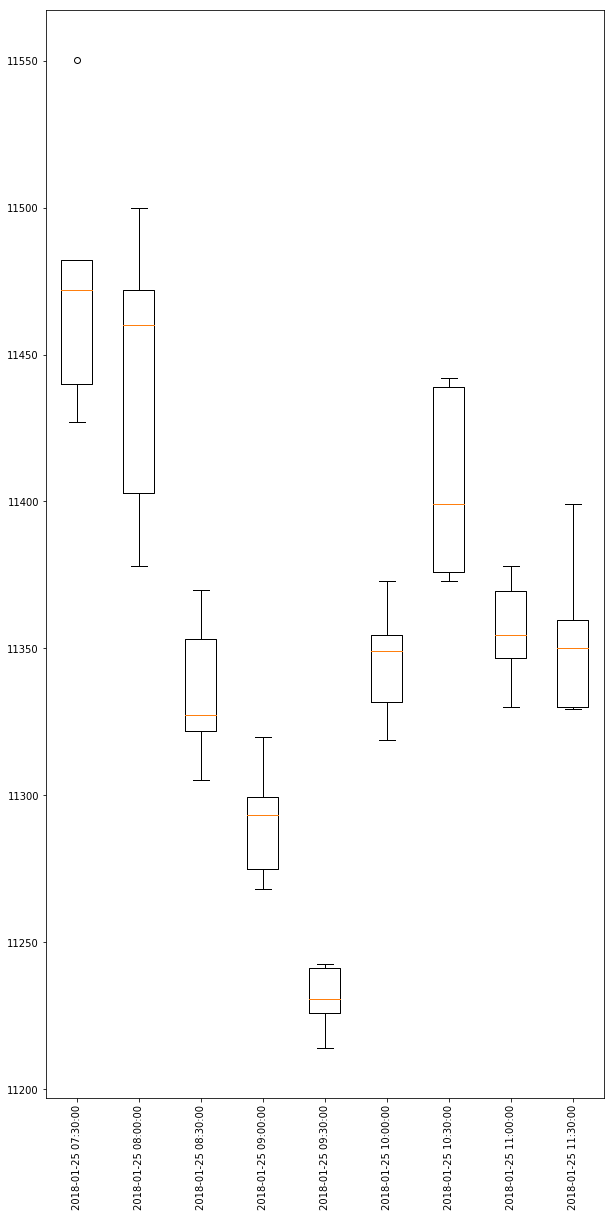

In [29]:
fig = plt.figure(1, figsize=(10, 20))  # Create a figure instance
#plt.title("CoinMarketCap(Blue) vs Volume-weighted Average(Red) vs Top 10 Exchanges Price Distribution")
ax = fig.add_subplot(111)  # Create an axes instance
ax.boxplot(Data_to_plot[1:10], labels=Data_xvalue[1:10])
plt.xticks(rotation=90)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 9 Text xticklabel objects>)

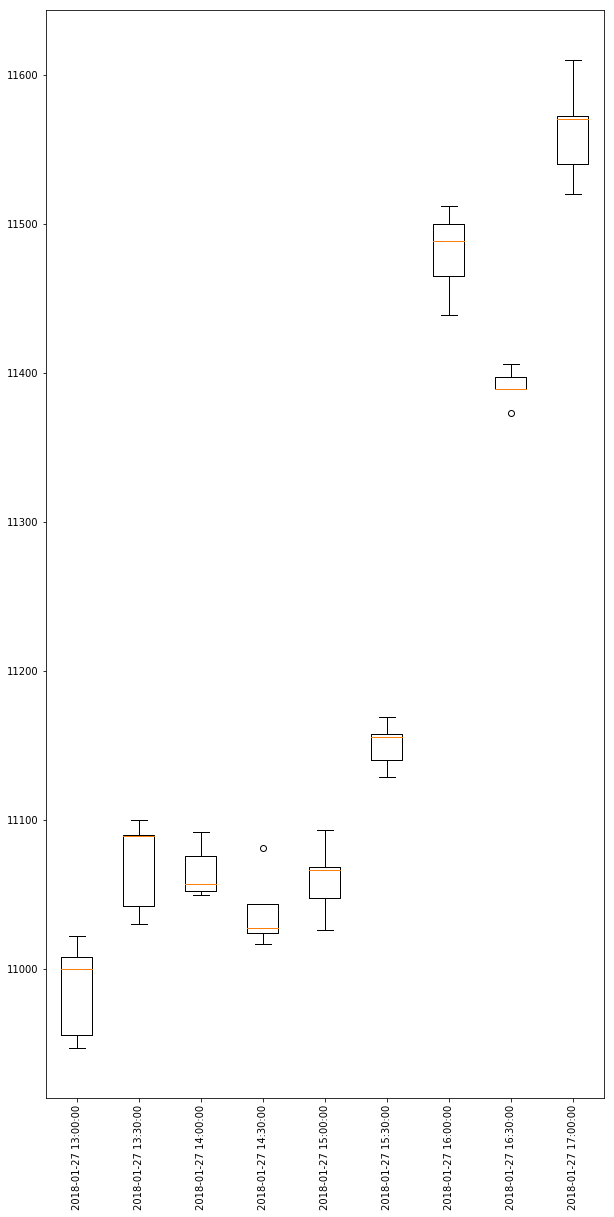

In [30]:
fig = plt.figure(1, figsize=(10, 20))  # Create a figure instance
#plt.title("CoinMarketCap(Blue) vs Volume-weighted Average(Red) vs Top 10 Exchanges Price Distribution")
ax = fig.add_subplot(111)  # Create an axes instance
ax.boxplot(Data_to_plot[101:110], labels=Data_xvalue[101:110])
plt.xticks(rotation=90)

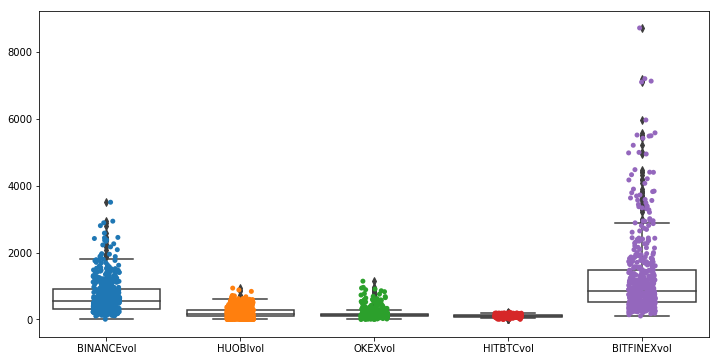

In [21]:
from pandas import TimeGrouper
import seaborn
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
ax = fig.add_subplot(111)
ax = seaborn.boxplot(data=VolDF[:500], boxprops={'facecolor':'None'})
ax = seaborn.stripplot(data=VolDF[:500])

#ax = seaborn.swarmplot(data=VolDF[:500])

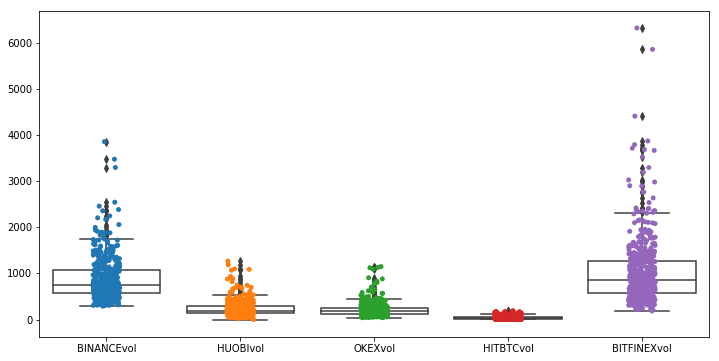

In [24]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
ax = fig.add_subplot(111)
ax = seaborn.boxplot(data=VolDF[501:1000], boxprops={'facecolor':'None'})
ax = seaborn.stripplot(data=VolDF[501:1000])


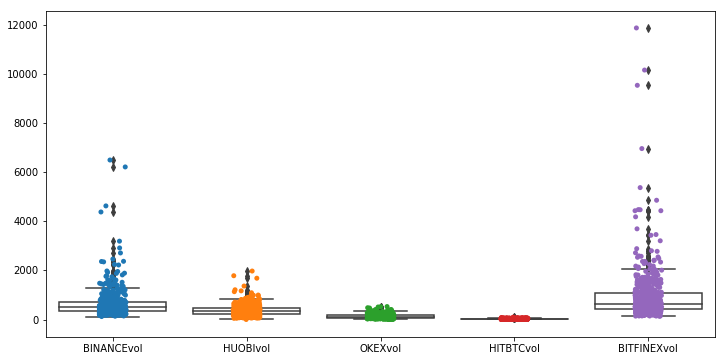

In [25]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
ax = fig.add_subplot(111)
ax = seaborn.boxplot(data=VolDF[1001:1500], boxprops={'facecolor':'None'})
ax = seaborn.stripplot(data=VolDF[1001:1500])

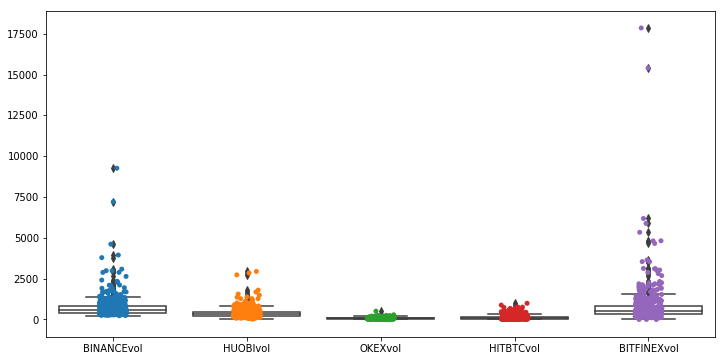

In [27]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
ax = fig.add_subplot(111)
ax = seaborn.boxplot(data=VolDF[3001:3500], boxprops={'facecolor':'None'})
ax = seaborn.stripplot(data=VolDF[3001:3500])

In [ ]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
plt.title("CoinMarketCap vs Top 9 Exchanges")
ax = seaborn.boxplot(data=vsCMC, boxprops={'facecolor':'None'})
ax = seaborn.swarmplot(data=vsCMC)

In [ ]:
def get_weights(DF_name, DF_key):
    DF_name['wt'+DF_key] = DF_name[DF_key] / DF_name.sum(axis=1)
    
get_weights(VolDF, 'BINANCEvol')
get_weights(VolDF, 'HUOBIvol')
get_weights(VolDF, 'OKEXvol')
get_weights(VolDF, 'HITBTCvol')
get_weights(VolDF, 'BITFINEXvol')
##################################
#get_weights(VolDF, "BITMEXvol")
#get_weights(VolDF, "BITSTAMPvol")
#get_weights(VolDF, 'COINBASEvol')
#get_weights(VolDF, 'POLONIEXvol')

JoinedDF['Weighted_Avg'] = np.zeros(len(JoinedDF))

summation = 0.0
for key_name in Top10:
    multiply = JoinedDF[key_name] * VolDF['wt'+key_name+'vol']
    JoinedDF['Weighted_Avg'] = JoinedDF['Weighted_Avg'] + multiply
    del multiply
    
print(JoinedDF.head())


### Get CoinMarketCap Data

In [ ]:
#CMC = pd.read_csv("./CoinMarketCap.csv", sep=",", header=["Date", "CoinMarketCap"])
CMC = pd.read_csv("./CoinMarketCap.csv")
CMC['Date'] = CMC['Date'].apply(pd.to_datetime, errors='coerce')
CMC.index = CMC['Date']
CMC = CMC.sort_values(by='Date')
CMC = CMC[["CoinMarketCap"]] # remove Date Column
CMC.head()

In [ ]:
Time_main = list(JoinedDF.index)
Time_CMC = list(CMC.index)
Weight_mean = JoinedDF[['Weighted_Avg']]
#JoinedDF = JoinedDF[Top5]
JoinedDF = JoinedDF[Top10]
def intersection(list1, list2):
    return list(set(list1) & set(list2))

Data_index = intersection(Time_main, Time_CMC)

Data_to_plot = []
Data_xvalue = []
Data_CMC = []
Data_weight_avg = []
for ii in Data_index:
    idx = ii.strftime('%Y-%m-%d %H:%M:%S')    
    Data_to_plot.append(tuple(JoinedDF.loc[idx]))
    Data_CMC.append(tuple(CMC.loc[idx]))
    Data_weight_avg.append(tuple(Weight_mean.loc[idx]))
    Data_xvalue.append(idx) 

# 2018-01-26 ~ 2018-08-17

In [ ]:
vsCMC = pd.merge(CMC, JoinedDF, how='inner', left_index=True, right_index=True)
vsCMC.head()

In [ ]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
ax = fig.add_subplot(111)  # Create an axes instance
#ax.scatter(x = Data_xvalue[:4], y =Data_CMC[:4], s=12)
ax.boxplot(Data_to_plot[:4], labels=Data_xvalue[:4])

In [ ]:
fig = plt.figure(1, figsize=(10, 20))  # Create a figure instance
plt.title("CoinMarketCap(Blue) vs Volume-weighted Average(Red) vs Top 10 Exchanges Price Distribution")
ax = fig.add_subplot(111)  # Create an axes instance
ax.scatter(x = Data_xvalue[:10], y =Data_CMC[:10], c="blue", s=12)
ax.scatter(x = Data_xvalue[:10], y =Data_weight_avg[:10], c="red", s=12)
ax.boxplot(Data_to_plot[1:10], labels=Data_xvalue[1:10])
plt.xticks(rotation=90)

In [ ]:
fig = plt.figure(1, figsize=(10, 20))  # Create a figure instance
plt.title("CoinMarketCap(Blue) vs Volume-weighted Average(Red) vs Top 10 Exchanges Price Distribution")
ax = fig.add_subplot(111)  # Create an axes instance
ax.scatter(x = Data_xvalue[19:30], y =Data_CMC[19:30], c="blue", s=12)
ax.scatter(x = Data_xvalue[20:30], y =Data_weight_avg[20:30], c="red", s=12)
ax.boxplot(Data_to_plot[20:30], labels=Data_xvalue[20:30])
plt.xticks(rotation=90)

In [ ]:
from pandas import TimeGrouper
import seaborn
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
#ax = fig.add_subplot(111)  # Create an axes instance
ax = seaborn.boxplot(data=Data_to_plot[100:102], boxprops={'facecolor':'None'})
#ax = seaborn.stripplot(data=Data_to_plot[100:102])
ax = seaborn.swarmplot(data=Data_to_plot[100:102])

In [ ]:
print(JoinedDF.index[:400])

In [ ]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
plt.title("Top 9 Exchanges BTC/USD Distribution [2018-01-25 01:00:00 ~ 2018-02-09 21:00:00]")
ax = seaborn.boxplot(data=JoinedDF, boxprops={'facecolor':'None'})
ax = seaborn.swarmplot(data=JoinedDF[:400], alpha=.5 )

In [ ]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
plt.title("Top 9 Exchanges BTC/USD Distribution")
ax = seaborn.boxplot(data=JoinedDF, boxprops={'facecolor':'None'})
ax = seaborn.swarmplot(data=JoinedDF[401:800], alpha=.5)

In [ ]:
fig = plt.figure(1, figsize=(12, 6))  # Create a figure instance
plt.title("CoinMarketCap vs Top 9 Exchanges")
ax = seaborn.boxplot(data=vsCMC, boxprops={'facecolor':'None'})
ax = seaborn.swarmplot(data=vsCMC)